In [1]:
import pandas as pd
import numpy as np
import os
from analysis import *
import glob
import string
import plotly.graph_objects as go

In [2]:
colors = ['#e6194B', '#3cb44b', '#ffe119','#f58231','#42d4f4',
          '#f032e6','#fabed4','#469990','#aaffc3','#000075','#e6194B','#9a6324','#dcbeff', 
          '#42d4f4', '#aaffc3', '#000075', '#aaffc3', '#fabed4', '#3cb44b', '#f58231',
          '#f032e6','#fabed4','#469990','#aaffc3','#000075','#e6194B','#9a6324','#dcbeff', 
          # '#dcbeff', '#dcbeff', '#dcbeff'
         ]
plotted_models = ['DPN','ReXNet', 'EseVoVNet', 'TNT', 'Inception', 'HRNet', 'MobileNet', 'VGG19', 'ResNet-RS', 
                 'DenseNet', 'DPN_Magface', 'DPN_Cosface', 'SMAC', 
                 'VisFormer', 'XCeption', 'TF_EfficientNet', 'gluon_xception65', 'dla102x2', 
                 'convit_base', 'twins_svt_large', 'Swin', 'cspdarknet53', 'FBNet', 'JX_Net', 
                 # 'legacy_senet154', 'selecsls60b', 'coat_lite_small',
                 ]

## Phase 1

In [3]:
models = get_finished_models_Phase1B()

rank_files = glob.glob('Phase1B/**/*_rank_by_id_val.csv')
rank_files += glob.glob('timm_explore_few_epochs/**/*_rank_by_id_val.csv')
rank_files_Phase1 = [x for x in rank_files if any([m in x for m in models])]
kacc_files = glob.glob('**/**/*_kacc_val.csv')
metadata = pd.read_csv('val_identities_gender-expression_seed_222.csv')

epochs = ['epoch_'+str(i) for i in [99]]

acc_df, acc_disp_df, rank_df = analyze_rank_files(rank_files_Phase1, metadata, epochs=epochs)
_, acc_disp_ratio_df, rank_ratio_df = analyze_rank_files(rank_files_Phase1, metadata, ratio=True, epochs=epochs)
err_df, error_ratio_df, _ = analyze_rank_files(rank_files_Phase1, metadata, ratio=True, error=True, epochs=epochs)
acc_df['Metric'] = 1 - acc_df['Metric']

In [66]:
celeba = merge(acc_df, acc_disp_df)
celeba = merge(celeba, rank_df)
celeba = celeba.rename(columns={"Metric": "Rank Disparity", "Accuracy": "Error"})
celeba = merge(celeba, acc_disp_ratio_df)
celeba = celeba.rename(columns={"Metric": "Ratio"})
celeba = merge(celeba, rank_ratio_df)
celeba = celeba.rename(columns={"Metric": "Rank Ratio"})
celeba = merge(celeba, error_ratio_df)
celeba = celeba.rename(columns={"Metric": "Error Ratio"})
celeba.to_csv("celeba_val_results.csv", index=False)

In [4]:
pickle_files = []
for model in glob.glob('vggface2_train/*'):
    if 'Checkpoint' in model:
        continue
    pickle_files += [glob.glob(model+'/*[!ema].pkl')]
metadata = pd.read_csv('vggface2_val_identities_gender.csv')

epochs = [f'epoch_{x}' for x in range(10,11)]

acc_df_vgg, acc_disp_df_vgg, rank_df_vgg = analyze_pickle_files(pickle_files, metadata, epochs=epochs)
_, acc_disp_ratio_df_vgg, rank_ratio_df_vgg = analyze_pickle_files(pickle_files, metadata, ratio=True, epochs=epochs)
err_df_vgg, error_ratio_df_vgg, _ = analyze_pickle_files(pickle_files, metadata, ratio=True, error=True, epochs=epochs)
acc_df_vgg['Metric'] = 1 - acc_df_vgg['Metric']

In [65]:
vgg = merge(acc_df_vgg, acc_disp_df_vgg)
vgg = merge(vgg, rank_df_vgg)
vgg = vgg.rename(columns={"Metric": "Rank Disparity", "Accuracy": "Error"})
vgg = merge(vgg, acc_disp_ratio_df_vgg)
vgg = vgg.rename(columns={"Metric": "Ratio"})
vgg = merge(vgg, rank_ratio_df_vgg)
vgg = vgg.rename(columns={"Metric": "Rank Ratio"})
vgg = merge(vgg, error_ratio_df_vgg)
vgg = vgg.rename(columns={"Metric": "Error Ratio"})
vgg.to_csv("vgg_val_results.csv", index=False)

In [63]:
def plot_validation(metric_name, metric_suffix, fairness_df, 
                    dataset='VGGFace2', show_all=False, epoch=10):
    df = fairness_df
    df = df[df['epoch'] == epoch]
    df = df.dropna()
    if not show_all:
        df = df[df['Error']<0.3]
    else:
        df = df[df['Error']<1-1/(7636*2)]
        
    df.loc[:,'model'] = df['index'].apply(lambda x: get_name_details(x)[1])
    df = df.sort_values(by=['model'])
    # df = df.sort_values('Error')[:30]


    fig = px.scatter(df, x='Error', 
                     y=metric_name, 
                     template="simple_white", 
                     width=1000, height= 500
                )

    if not show_all:
        fig.update_layout(
            xaxis_range=[0,0.32],
        )
    
    fig.update_layout(
        yaxis_title=metric_name,
        title={
                'text' : f'{dataset} Validation Set',
                'x':0.5,
                'xanchor': 'center'
            },
        font=dict(
            family="Times New Roman",
            size=30,
            color="Black"
        )
    )
    fig.add_shape(type='line',
                    x0=0,y0=0,x1=1,y1=0,
                    line=dict(color='Red',),
                    xref='x',yref='y'
    )
    p = np.array(preparePareto(df[['Error',metric_name]], False, False).dropna())
    for x, y in zip(p[:-1], p[1:]):
        fig.add_shape(type='line',
                    x0=x[0],y0=x[1],x1=y[0],y1=y[1],
                    line=dict(color='gray',width=4),line_dash='dash',
                    xref='x',yref='y')


    pareto_df = pd.merge(df, pd.DataFrame(p), right_on=[0,1], left_on=["Error",metric_name])
    
    if pareto_df.shape[0]<7:
        y_anchor, x_anchor = -.29, .6
    else:
        y_anchor, x_anchor = -.6, .7
        
    fig.update_layout(legend=dict(
        orientation="h",
        # yanchor="bottom",
        # y=-.49,
        # xanchor="right",
        # x=.63,
        yanchor="top",
        y=-.49,
        xanchor="center",
        x=0.5,
        font=dict(
            family="Times New Roman",
            size=24,
            color="Black"
        )
        )
    )

    for model in set(pareto_df['model']):
        # match model name to color
        i = [x.lower()[:3] for x in plotted_models].index(model.lower()[:3])
        name = plotted_models[i]
        color = colors[i]
        fig.add_trace(go.Scatter(
            x=pareto_df[pareto_df['model'] == model]['Error'],
            y=pareto_df[pareto_df['model'] == model][metric_name],
            mode='markers',
            name = name,
            marker = dict(color=color,size=15),
        ))

    fig.show()
    # plotly.io.write_image(fig, f'RQ1_main_{dataset}_{metric_suffix}_17052023.pdf', format='pdf')
    return df


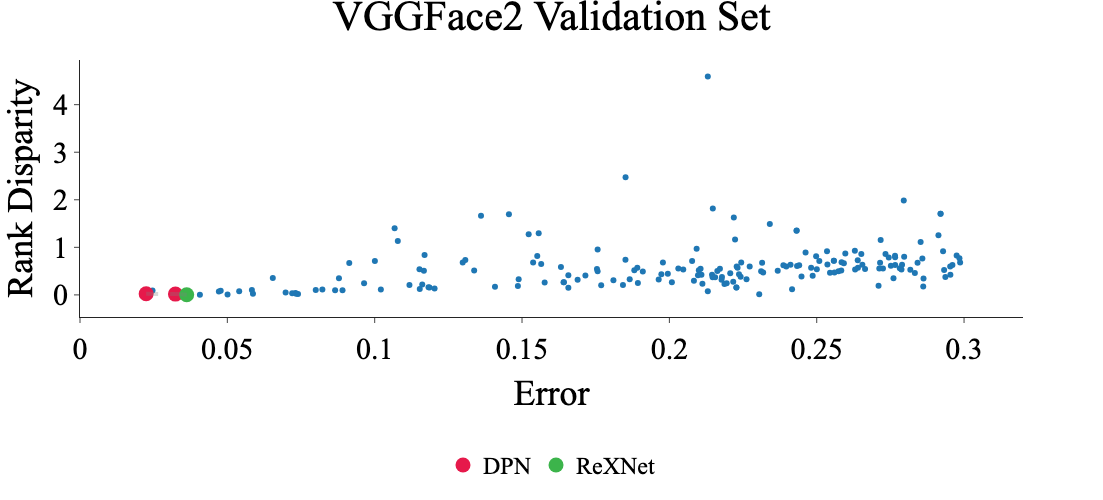

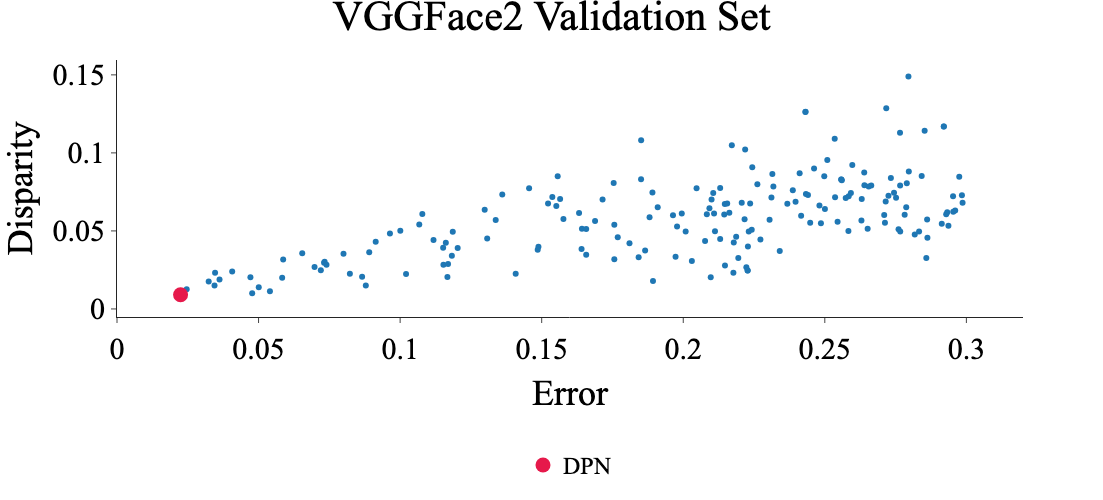

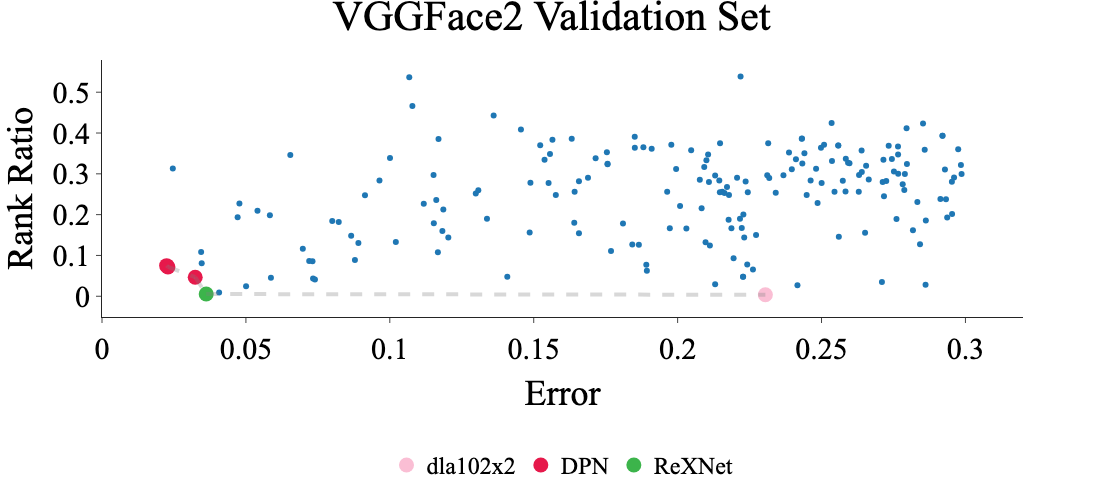

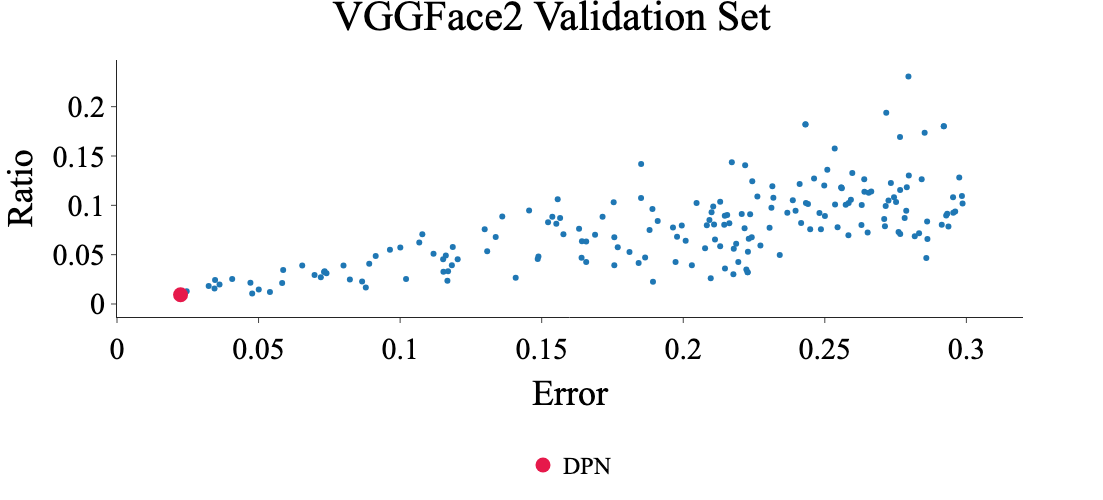

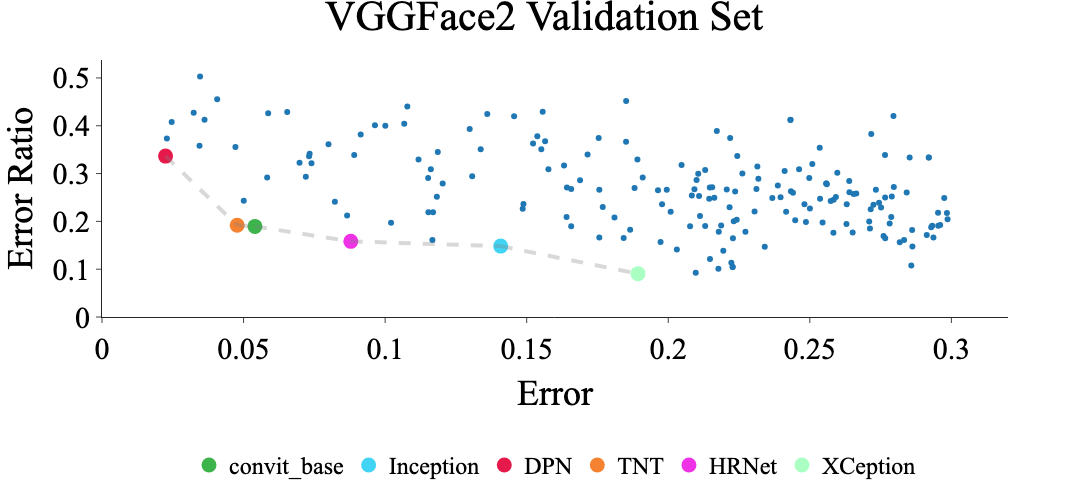

,index,epoch,Error,Disparity,Rank Disparity,Ratio,Rank Ratio,Error Ratio,model
295,coat_lite_small_CosFace_AdamW,10,0.073333,0.030196,0.025817,0.033125,0.043608,0.341463,coat_lite_small
195,coat_lite_small_CosFace_AdamW_0.001_cosine,10,0.047124,0.020392,0.072745,0.021632,0.193801,0.355758,coat_lite_small
316,convit_base_CosFace_SGD,10,0.185131,0.108039,2.475163,0.141998,0.363914,0.451763,convit_base
45,convit_base_CosFace_AdamW,10,0.054020,0.011307,0.077908,0.012025,0.209711,0.189485,convit_base
196,convit_base_CosFace_AdamW_0.001_cosine,10,0.058333,0.019935,0.103987,0.021396,0.198478,0.291866,convit_base
...,...,...,...,...,...,...,...,...,...
147,xception65_ArcFace_AdamW,10,0.291307,0.054641,1.254641,0.080192,0.238152,0.171487,xception65
250,xception65_CosFace_SGD,10,0.184248,0.033203,0.210327,0.041547,0.126948,0.165311,xception65
110,xception65_MagFace_AdamW_0.001_cosine,10,0.265490,0.078431,0.634118,0.112803,0.319502,0.257400,xception65
187,xception65_CosFace_AdamW_0.001_cosine,10,0.189314,0.017974,0.252353,0.022420,0.062268,0.090639,xception65


In [62]:
plot_validation('Rank Disparity', '', vgg, show_all=False)
plot_validation('Disparity','disparity', vgg, show_all=False)
plot_validation('Rank Ratio', 'rank_ratio', vgg, show_all=False)
plot_validation('Ratio', 'ratio', vgg, show_all=False)
plot_validation('Error Ratio', 'error_ratio', vgg, show_all=False)

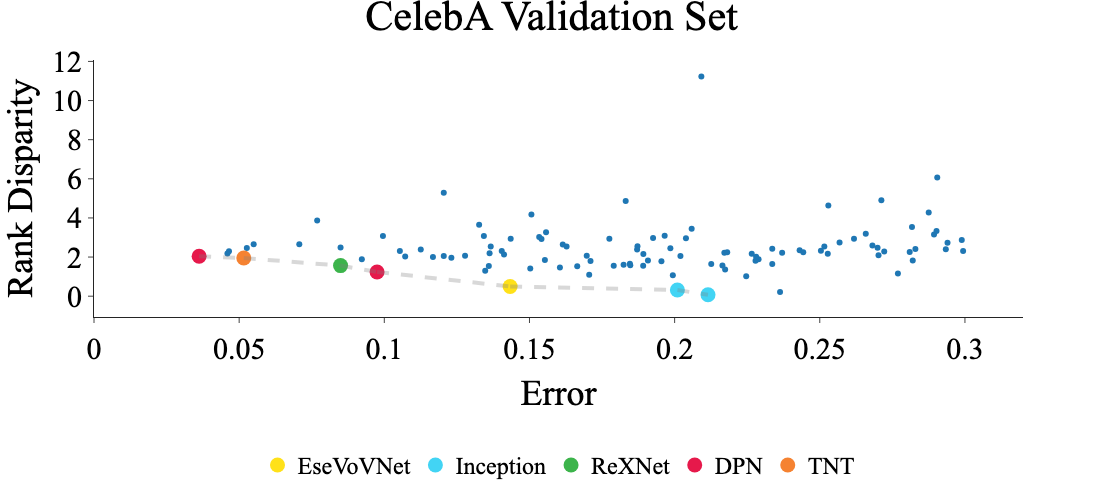

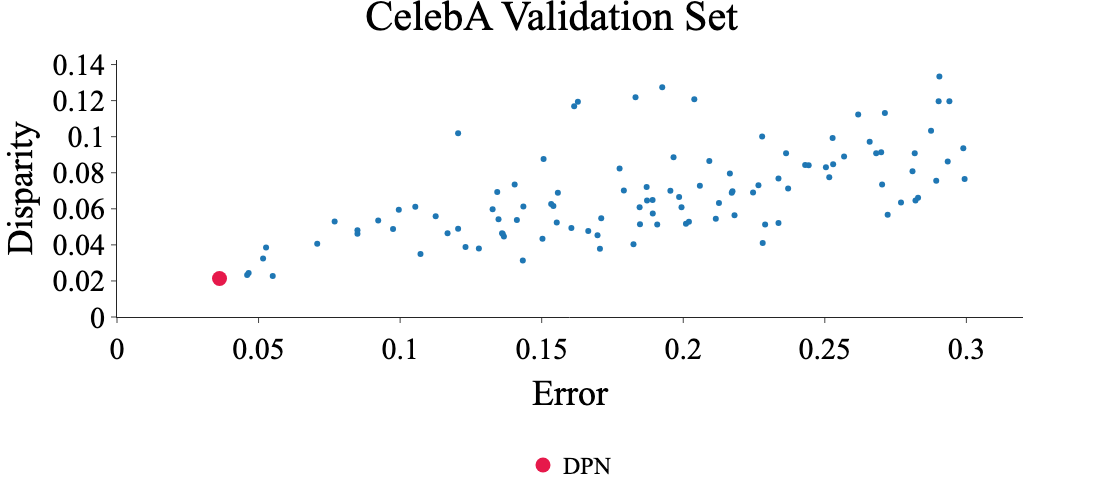

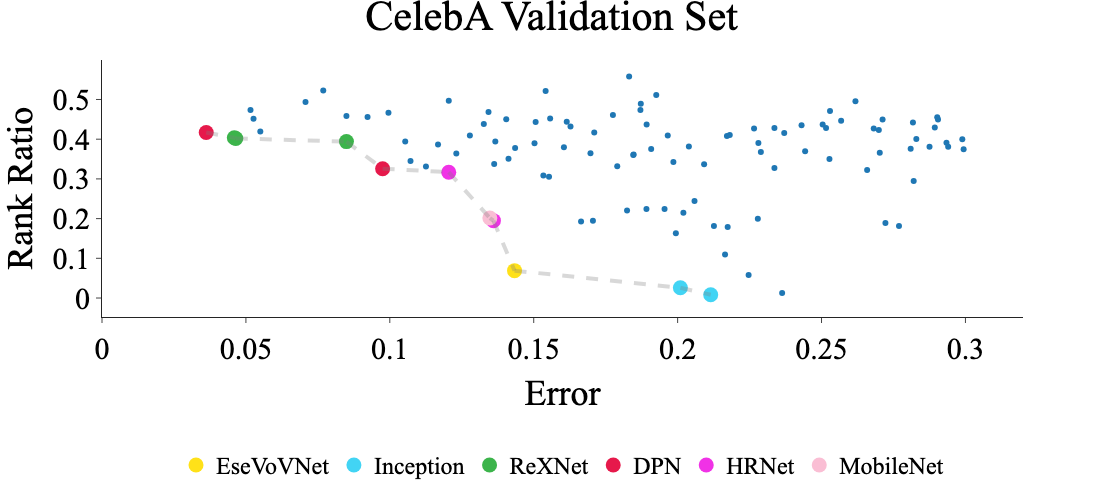

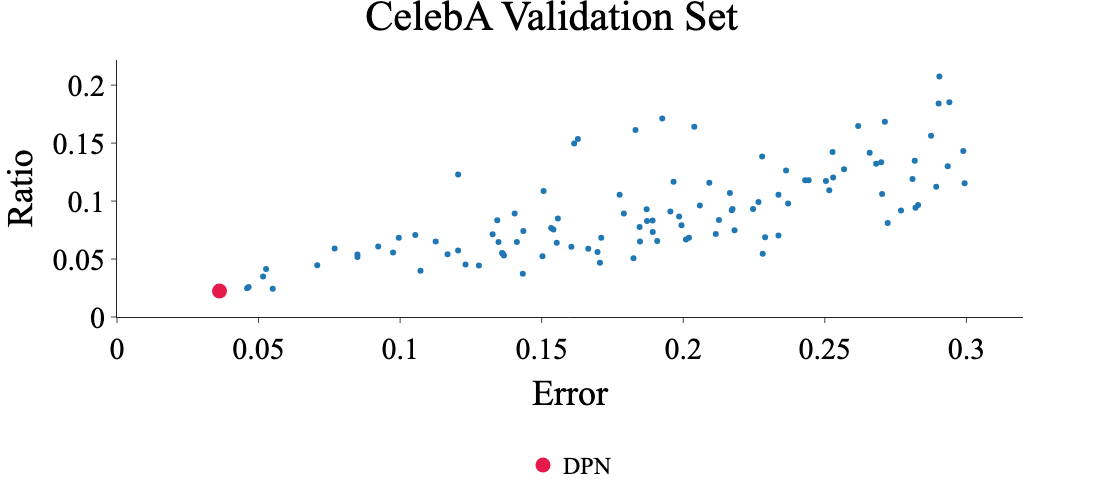

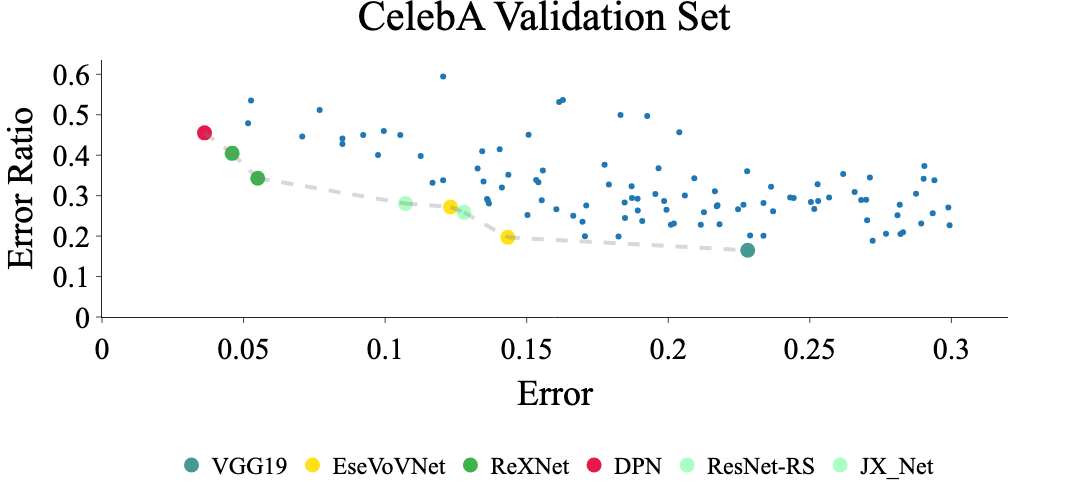

,index,epoch,Error,Disparity,Rank Disparity,Ratio,Rank Ratio,Error Ratio,model
343,coat_lite_small_CosFace_AdamW_rank_by_id_val,99,0.120482,0.101886,5.292562,0.122965,0.497079,0.594347,coat_lite_small
157,coat_lite_small_CosFace_AdamW_0.001_cosine_ran...,99,0.076873,0.052907,3.864065,0.059004,0.522637,0.512041,coat_lite_small
306,coat_lite_small_CosFace_SGD_rank_by_id_val,99,0.290466,0.133316,6.061027,0.207374,0.449759,0.373304,coat_lite_small
349,convit_base_CosFace_SGD_rank_by_id_val,99,0.183146,0.121922,4.870613,0.161296,0.557635,0.499464,convit_base
98,cspdarknet53_MagFace_SGD_0.1_cosine_rank_by_id...,99,0.150275,0.043347,1.419068,0.052349,0.390051,0.252094,cspdarknet53
...,...,...,...,...,...,...,...,...,...
177,xception_CosFace_SGD_0.1_cosine_rank_by_id_val,99,0.271215,0.113148,4.909508,0.168323,0.449627,0.345186,xception
236,xception_MagFace_AdamW_rank_by_id_val,99,0.218112,0.056443,2.245678,0.074891,0.410740,0.229133,xception
137,xception_ArcFace_SGD_0.1_cosine_rank_by_id_val,99,0.202004,0.052776,2.051205,0.068398,0.214877,0.231078,xception
64,xception65_ArcFace_SGD_rank_by_id_val,99,0.226558,0.073075,2.163305,0.099165,0.426803,0.277750,xception65


In [67]:
plot_validation('Rank Disparity', '', celeba, dataset='CelebA', show_all=False, epoch=99)
plot_validation('Disparity','disparity', celeba, dataset='CelebA', show_all=False, epoch=99)
plot_validation('Rank Ratio', 'rank_ratio', celeba, dataset='CelebA', show_all=False, epoch=99)
plot_validation('Ratio', 'ratio', celeba, dataset='CelebA', show_all=False, epoch=99)
plot_validation('Error Ratio', 'error_ratio', celeba, dataset='CelebA', show_all=False, epoch=99)

## Phase 2